# This notebook is to explore the possibility of using fast embedding method to embed the whole Kapoor network

In [32]:
import sys
sys.path.append("../..")
import pandas as pd
import os
from sys import platform 
from src.embedding.network_embedding import *
from src.eda.eda_functions import (plot_gene_cnt_each_cluster, get_closest_genes_jaccard, 
                                   cluster_jaccard_v2, run_kmeans, cluster_DE_perc, 
                                   plot_gene_cnt_each_cluster_v2, plot_cluster_nmi_comparison_v3)
prefix = 'G:' if platform == 'win32' else '/Volumes/GoogleDrive'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
%%time
tom_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/Kapoor_TOM.csv', index_col = 0)

Wall time: 5min 15s


In [3]:
%%time
edge_df = adj_to_edgelist(tom_df, 'Kapoor', output_dir = prefix + '/Shared drives/NIAAA_ASSIST/Data/eda_derived')

Kapoor_edge.txt has been saved.
Wall time: 36min 31s


In [4]:
%%time
embedding_path = prefix+'/Shared drives/NIAAA_ASSIST/Data/embedding_derived/embedding_Feb16'
emb_df = network_embedding_fast(prefix + '/Shared drives/NIAAA_ASSIST/Data/eda_derived/Kapoor_edge.txt', 
                                max_epoch = 100 ,learning_rate = 0.1, 
                                output_dir = embedding_path, name_spec = 'epoch=100_alpha=0.1')

KeyboardInterrupt: 

In [26]:
%%time
emb_df = network_embedding_fast(prefix + '/Shared drives/NIAAA_ASSIST/Data/eda_derived/Kapoor_edge.txt', 
                                max_epoch = 80 ,learning_rate = 0.1, 
                                output_dir = embedding_path, name_spec = 'epoch=80_alpha=0.1')

embedding data saved
Wall time: 2h 34min 49s


In [32]:
%%time
emb_df = network_embedding_fast(prefix + '/Shared drives/NIAAA_ASSIST/Data/eda_derived/Kapoor_edge.txt', 
                                max_epoch = 200 ,learning_rate = 0.1, tol_samples=20,
                                output_dir = embedding_path, name_spec = 'epoch=200_alpha=0.1_tol_samples=20')

embedding data saved
Wall time: 52min 48s


# Improved embedding speed by converting data format used in CSRGraph

In [2]:
%%time
m1 = memory_profiler.memory_usage()
prefix = 'G:'
embedding_path = prefix+'/Shared drives/NIAAA_ASSIST/Data/embedding_derived/embedding_March4'
emb_df = network_embedding_fast(prefix + '/Shared drives/NIAAA_ASSIST/Data/eda_derived/Kapoor_edge.txt', 
                                max_epoch = 100 ,learning_rate = 0.1, 
                                output_dir = embedding_path, name_spec = 'test')
m2 = memory_profiler.memory_usage()

using modified csrgraph
memory1 11129.15625
elist size 1 60257057664
memory2 5104.0
elist size 2 4757136264
memory3 3591.74609375
elist size 3 3171424224
embedding data saved
Wall time: 2h 43min 24s


In [6]:
print(m2[0]-m1[0])

-116.3671875


# Load all embeddings

In [56]:
embedding_path = prefix+'/Shared drives/NIAAA_ASSIST/Data/embedding_derived/embedding_March4'

In [44]:
emb1 = pd.read_csv(os.path.join(embedding_path, 'embedded_ggvec_fast_epoch=100_alpha=0.1.csv'), index_col = 0)
emb_list = [emb1]
emb_names = ['fast_epoch=100_alpha=0.1']
kmeans_list = [run_kmeans(emb1, 10)]
embedding_path = prefix+'/Shared drives/NIAAA_ASSIST/Data/embedding_derived/embedding_Feb16'

for file in os.listdir(embedding_path):
    emb = pd.read_csv(os.path.join(embedding_path, file), index_col = 0)
    emb_list.append(emb)
    emb_names.append(file.split('ggvec_')[1][:-4])
    kmeans_list.append(run_kmeans(emb, 10))

In [45]:
emb_names

['fast_epoch=100_alpha=0.1',
 'epoch=100_alpha=0.1',
 'epoch=80_alpha=0.1',
 'epoch=200_alpha=0.1_tol_samples=20']

In [2]:
# embedding_path = prefix+'/Shared drives/NIAAA_ASSIST/Data/embedding_derived/embedding_Feb16'
# emb_name = 'embedded_ggvec_epoch=100_alpha=0.1.csv'.split('ggvec_')[1][:-4]
# emb_df = pd.read_csv(os.path.join(embedding_path, 'embedded_ggvec_epoch=100_alpha=0.1.csv'), index_col = 0)
# kmeans = run_kmeans(emb_df, 10)

In [18]:
deseq = pd.read_excel(prefix + '/Shared drives/NIAAA_ASSIST/Data/deseq.alc.vs.control.age.rin.batch.gender.PMI.corrected.w.prot.coding.gene.name.xlsx')
deseq['abs_log2FC'] = abs(deseq['log2FoldChange'])

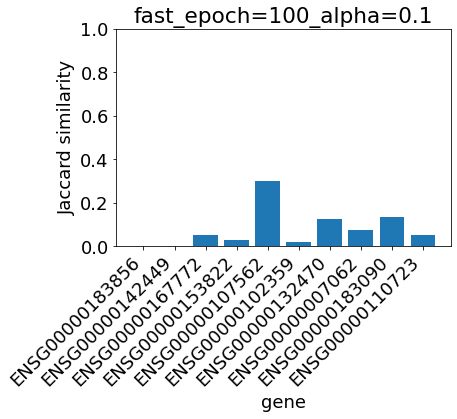

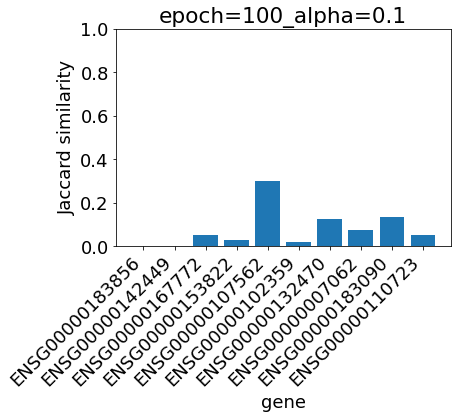

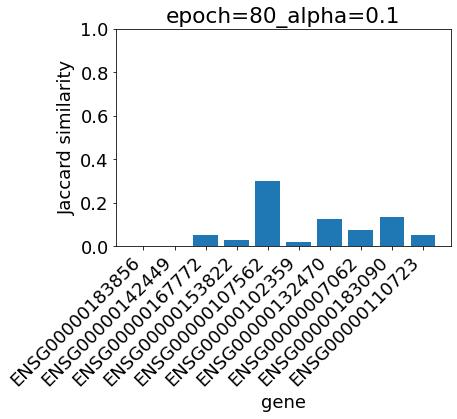

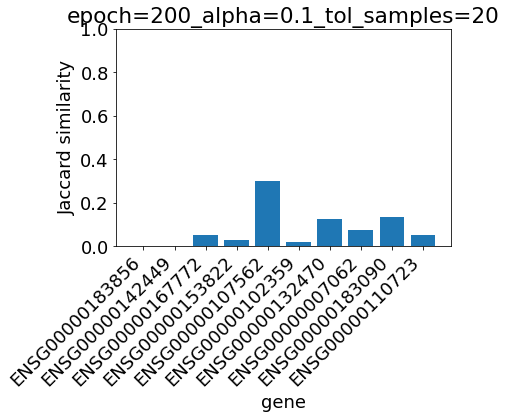

In [32]:
top_n_de = deseq.sort_values('abs_log2FC', ascending = False)['id'][10:20]
for emb, name in zip(emb_list, emb_names):
    get_closest_genes_jaccard(tom_df, emb, top_n_de, 50, name)

In [34]:
louvain_default = pd.read_csv(prefix+'/Shared drives/NIAAA_ASSIST/Data/eda_derived/network_louvain_default.csv')

In [20]:
# wgcna_modules = pd.read_csv(prefix+'/Shared drives/NIAAA_ASSIST/Data/eda_derived/wgcna_modules.csv')

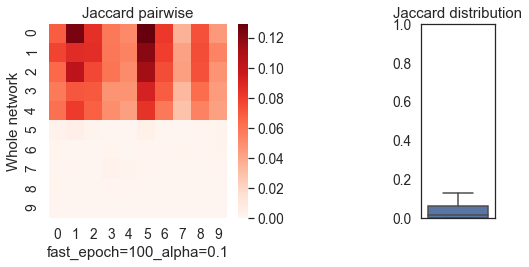

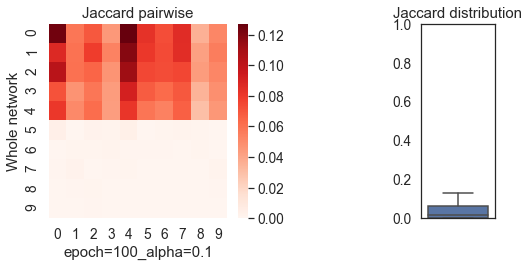

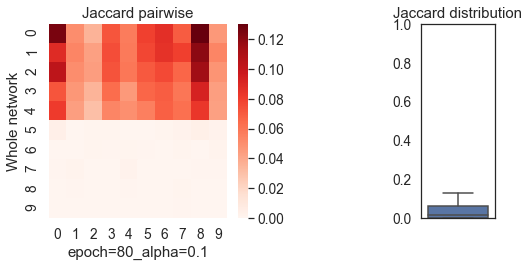

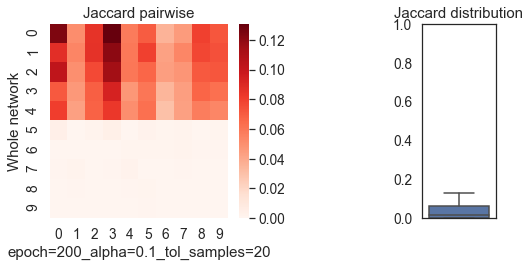

In [46]:
for kmeans, name in zip(kmeans_list, emb_names):
    cluster_jaccard_v2(louvain_default, kmeans, 'louvain_label', 'kmean_label', ['Whole network', name])

Removing existing folder: output
Created folder output


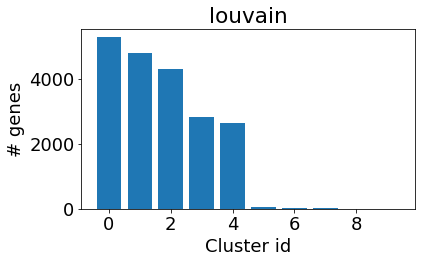

In [3]:
plot_gene_cnt_each_cluster([louvain_default], 'louvain_label', ['louvain'])

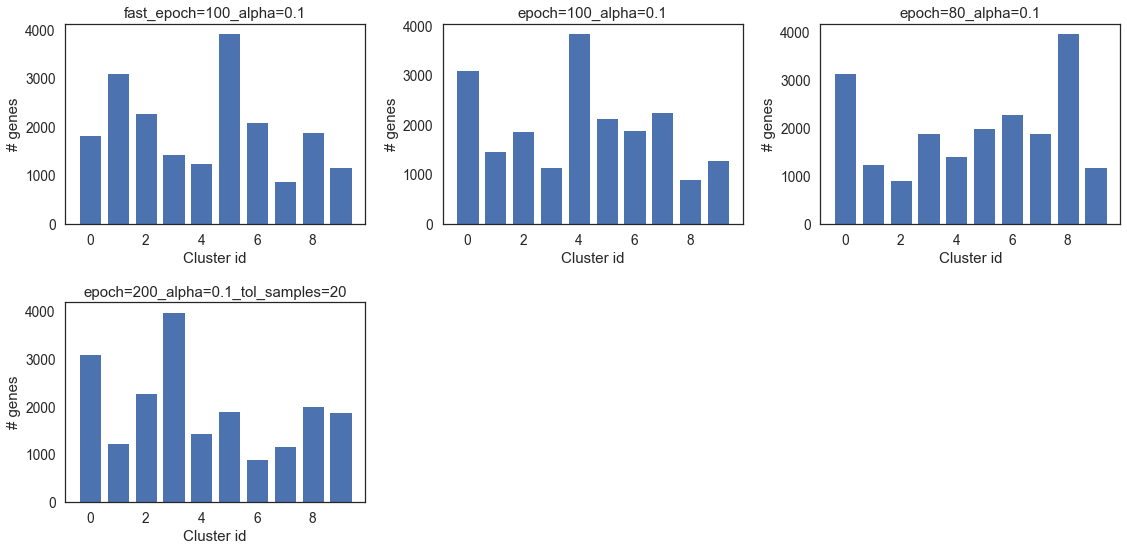

In [36]:
plot_gene_cnt_each_cluster(kmeans_list, 'kmean_label', emb_names)

In [ ]:
## plot_gene_cnt_each_cluster_v2() to plot just 1 graph at a time

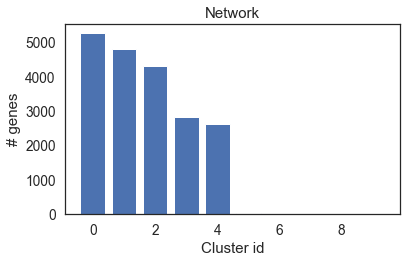

In [22]:
plot_gene_cnt_each_cluster_v2(louvain_default, 'louvain_label', 'Network', '_network')

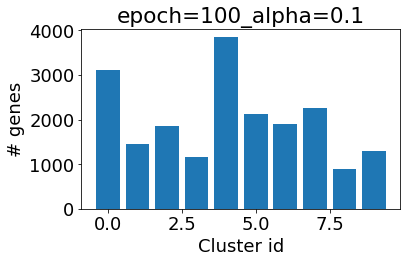

In [10]:
plot_gene_cnt_each_cluster_v2(kmeans, 'kmean_label', emb_name, '_embedding')

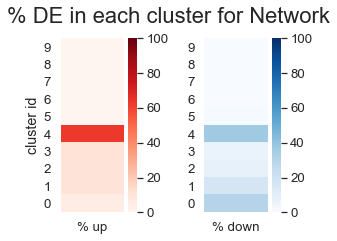

In [6]:
cluster_DE_perc(louvain_default, 'louvain_label', 'Network', deseq)

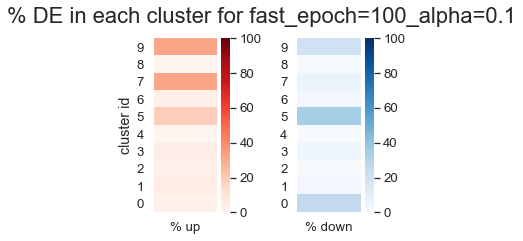

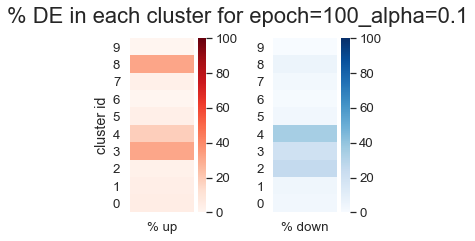

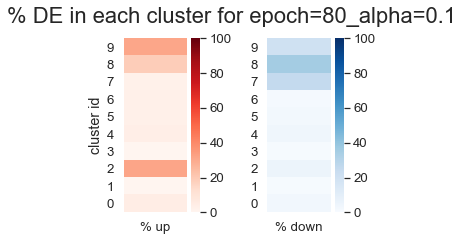

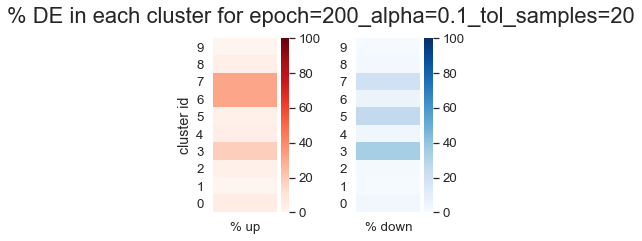

In [47]:
for kmeans, name in zip(kmeans_list, emb_names):
    cluster_DE_perc(kmeans, 'kmean_label', name, deseq)

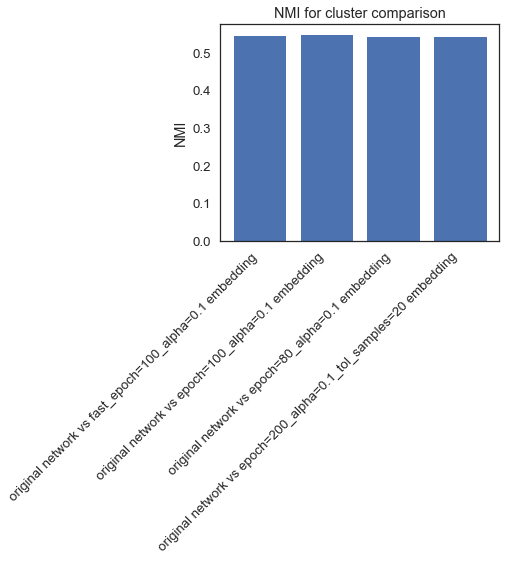

In [48]:
# for kmeans, name in zip(kmeans_list, emb_names):
network_comparison_names = ['original network' + f' vs {emb_names[i]} embedding' for i in range(len(emb_names))]
plot_cluster_nmi_comparison_v3('network', cluster1 = louvain_default, cluster1_column = 'louvain_label', 
                               cluster2_list= kmeans_list, cluster2_column = 'kmean_label', comparison_names = network_comparison_names)

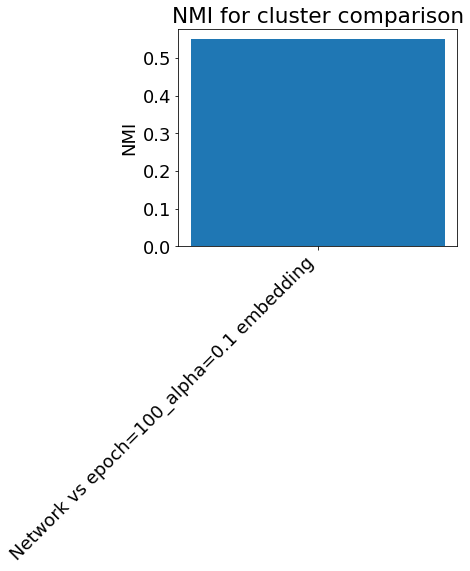

In [16]:
network_comparison_name = ['Network' + f' vs {emb_name} embedding']
plot_cluster_nmi_comparison_v3('Network', cluster1 = louvain_default, cluster1_column = 'louvain_label',
                               cluster2_list= [kmeans], cluster2_column = 'kmean_label', comparison_names = network_comparison_name)

# NMI comparison between using subnetwork embedding and whole network embedding

In [5]:
comm_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/eda_derived/network_louvain_default.csv')

In [6]:
deseq = pd.read_excel(prefix + '/Shared drives/NIAAA_ASSIST/Data/deseq.alc.vs.control.age.rin.batch.gender.PMI.corrected.w.prot.coding.gene.name.xlsx')

In [13]:
emb1 = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\embedding_derived\embedding_Jan12\embedded_len16_walk100_module[4]_n_[0]_df.csv', index_col = 0)

In [14]:
emb2 = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\embedding_derived\embedding_Jan12\embedded_len16_walk100_module[4]_n_[2]_df.csv', index_col = 0)

In [15]:
emb_list2 = [emb1, emb2, emb_list[0]]
emb_names = ['module[4]_n_[0]', 'module[4]_n_[2]', 'whole network']

In [16]:
wgcna_modules = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/eda_derived/wgcna_modules.csv')

In [18]:
kmeans_list = []
for emb in emb_list2:
    kmeans_list.append(run_kmeans(emb, 10))

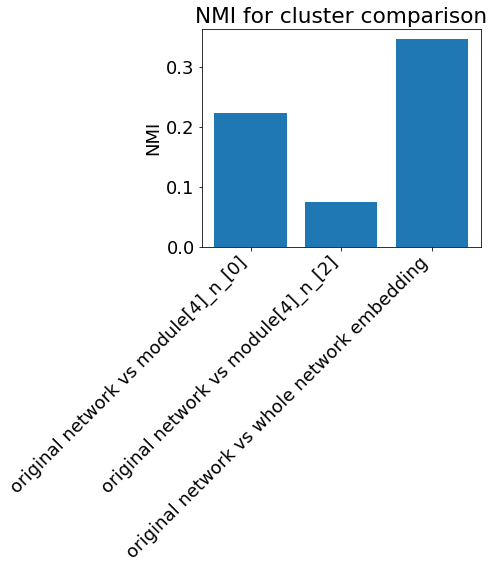

In [21]:
network_comparison_names = ['original network' + f' vs {emb_names[i]}' for i in range(len(emb_names))]
plot_cluster_nmi_comparison_v3('network', cluster1 = wgcna_modules, cluster1_column = 'louvain_label', 
                               cluster2_list= kmeans_list, cluster2_column = 'kmean_label', comparison_names = network_comparison_names)